In [1]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pyspark.sql.types as T
from pyspark.storagelevel import StorageLevel
from pyspark.sql import SparkSession

import jellyfish
from elasticsearch import Elasticsearch
import json
from datetime import datetime
import time
import yaml
import jellyfish
import sklearn

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.20) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# !pip install seaborn
# !pip install scikit-learn

In [3]:
import random

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

In [6]:
start = time.time()

In [7]:
spark = SparkSession.builder \
    .appName("TrainDataSet") \
    .master("spark://barravento:7077") \
    .config("spark.jars.packages", "org.elasticsearch:elasticsearch-spark-30_2.12:8.1.3") \
    .config("spark.es.nodes", "barravento") \
    .config("spark.es.port", "9200") \
    .config("spark.es.nodes.wan.only", "false") \
    .config("spark.es.resource", "dbb2") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.shuffle.partitions", 16) \
    .config("spark.sql.files.maxPartitionBytes", "256m") \
    .getOrCreate()

sc = spark.sparkContext
# just to ensure that 
sc.setCheckpointDir("hdfs://barravento:9000/spark-checkpoints")

Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.8/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.elasticsearch#elasticsearch-spark-30_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-14e6674f-eef2-49c5-9a83-c6ba57f56cec;1.0
	confs: [default]
	found org.elasticsearch#elasticsearch-spark-30_2.12;8.1.3 in central
	found org.scala-lang#scala-reflect;2.12.8 in central
	found org.slf4j#slf4j-api;1.7.6 in central
	found commons-logging#commons-logging;1.1.1 in central
	found javax.xml.bind#jaxb-api;2.3.1 in central
	found com.google.protobuf#protobuf-java;2.5.0 in central
	found org.apache.spark#spark-yarn_2.12;3.2.0 in central
:: resolution report :: resolve 303ms :: artifacts dl 3ms
	:: modules in use:
	com.google.protobuf#protobuf-java;2.5.0 from central in [default]
	commons-logging#commons-lo

# Lendo bases

In [10]:
link_df = spark.read.parquet('hdfs://barravento:9000/data/result/cidacsrl-result_2026-01-29_00-20-49.parquet')
link_df.limit(2).toPandas()

,id_cidacs_a,nome_a,nome_mae_a,dt_nasc_a,sexo_a,id_cidacs_b,nome_b,nome_mae_b,dt_nasc_b,sexo_b,vars,exact_queries,best_candidate_exact,sim_best_candidate_exact,similarity_exact_candidates,linked_from,non_exact_queries,best_candidate_non_exact,sim_best_candidate_non_exact,similarity_non_exact_candidates,final_cidacs_rl_score
0,212082,CLARA IASMIM DOS SANTOS,LORENA RIBEIRO BARBOSA,20091223,2,212082,CLARA IASMIM DOS SANTOS,LORENA RIBEIRO BARBOSA,20091223,2,"[212082, CLARA IASMIM DOS SANTOS, LORENA RIBEI...","{ ""bool"": { ""must"": [ {""match"": {""nome_a"":""CLA...",212082,1.0,"{129488=0.8115900254262465, 755330=0.823799389...",exact_match,None,None,NaN,None,1.0
1,642633,THIAGO BATISTA ALMEIDA JUNIRO,JOSIANE FELIX PEREIRA,20091214,1,642633,THIAGO BATISTA ALMEIDA JUNIRO,JOSIANE FELIX PEREIRA,20091214,1,"[642633, THIAGO BATISTA ALMEIDA JUNIRO, JOSIAN...","{ ""bool"": { ""must"": [ {""match"": {""nome_a"":""THI...",642633,1.0,"{15780=0.6942652042115105, 46768=0.84052552805...",exact_match,None,None,NaN,None,1.0


In [11]:
base_a = spark.read.parquet('hdfs://barravento:9000/data/synthetic-dataset-A.parquet')
base_a.limit(2).toPandas()

,id_cidacs_a,nome_a,nome_mae_a,dt_nasc_a,sexo_a
0,1,YASMIM VITORIA MATIAS FONSECA,TACIANY DOS SANTOS,20071122,2
1,2,PEDRO HENRIQUE MARTINS DE CARVALHO,FRANCILEIDE DOS SANTOS ALVES,20061102,1


In [12]:
base_b = spark.read.parquet('hdfs://barravento:9000/data/synthetic-datasets-b-1000.parquet')
base_b.limit(2).toPandas()

,id_cidacs_b,nome_b,nome_mae_b,dt_nasc_b,sexo_b
0,788,RUAN CESAR COSTA DE JESUS,JUSSARA CAROLINA R ALBUQUERQUE,20080531,1
1,1261,YASMIN MUNIZ MARCELINO,VERA LUCIA RIBEIRO,20080516,2


# Criando o best_candidate

In [13]:
link_df = link_df.withColumn("best_candidate", F.when(F.col("linked_from") == "exact_match", F.col("best_candidate_exact")).otherwise(F.col("best_candidate_non_exact")))

# Criando registros "lixo"

In [14]:
vector_a = base_a.select("id_cidacs_a").rdd.flatMap(lambda a: a).collect()

In [15]:
candidates_a = random.choices(vector_a, k=500)
candidates_b = random.choices(vector_a, k=500)

# Criando variável "match_status"

In [16]:
link_df = (
            link_df.select(["id_cidacs_a", "best_candidate"])
            .withColumn("match_status", F.when(F.col("id_cidacs_a") == F.col("best_candidate"), 1).otherwise(F.lit(0))) 
         )

print(link_df.select("match_status").groupBy("match_status").count().show())
link_df.limit(2).toPandas()

+------------+-----+
|match_status|count|
+------------+-----+
|           1| 1000|
+------------+-----+

None


,id_cidacs_a,best_candidate,match_status
0,212082,212082,1
1,642633,642633,1


In [17]:
df_ = spark.createDataFrame(
    list(zip(candidates_a, candidates_b)),
    schema=["id_cidacs_a", "best_candidate"]
).withColumn("match_status", F.lit(0))
df_.limit(2).toPandas()

,id_cidacs_a,best_candidate,match_status
0,897318,117112,0
1,679822,167765,0


In [18]:
link_df = link_df.union(df_)
link_df.select("match_status").groupBy("match_status").count().show()

[Stage 14:========================>                                (7 + 9) / 16]

+------------+-----+
|match_status|count|
+------------+-----+
|           1| 1000|
|           0|  500|
+------------+-----+



# Trazendo as variaveis de linkage

In [19]:
link_df = link_df.join(other=base_a,
                       on="id_cidacs_a",
                       how="left")\
                 .join(other=base_b,
                       on=link_df.best_candidate == base_b.id_cidacs_b,
                       how="left")\
                 .select(["id_cidacs_a", "id_cidacs_b",
                          "match_status",
                          "nome_a", "nome_b",
                          "nome_mae_a", "nome_mae_b",
                          "dt_nasc_a", "dt_nasc_b",
                          "sexo_a", "sexo_b"])
link_df.limit(5).toPandas()

,id_cidacs_a,id_cidacs_b,match_status,nome_a,nome_b,nome_mae_a,nome_mae_b,dt_nasc_a,dt_nasc_b,sexo_a,sexo_b
0,212082,212082,1,CLARA IASMIM DOS SANTOS,CLARA IASMIM DOS SANTOS,LORENA RIBEIRO BARBOSA,LORENA RIBEIRO BARBOSA,20091223,20091223,2,2
1,642633,642633,1,THIAGO BATISTA ALMEIDA JUNIRO,THIAGO BATISTA ALMEIDA JUNIRO,JOSIANE FELIX PEREIRA,JOSIANE FELIX PEREIRA,20091214,20091214,1,1
2,676225,676225,1,FERNANDO DA SILVA MAGALHAES,FERNANDO DA SILVA MAGALHAES,JEANE PRISCILLA LAMEIRA ROMA,JEANE PRISCILLA LAMEIRA ROMA,20100123,20100123,1,1
3,999994,999994,1,PEDRO HENRIQUE DE SOUZA DA SILVA,PEDRO HENRIQUE DE SOUZA DA SILVA,MARILENE BRASIL DA SILVA,MARILENE BRASIL DA SILVA,20110910,20110910,1,1
4,360116,360116,1,VALDEMIR DOUGLAS FERREIRA,VALDEMIR DOUGLAS FERREIRA,CRISTIANE DA SILVA SERGIO,CRISTIANE DA SILVA SERGIO,20101224,20101224,1,1


## Escrevendo

In [20]:
link_df.write.parquet("hdfs://barravento:9000/data/result/train_dataset_raw.parquet", mode="overwrite")

# Calculando similaridades

In [21]:
CONFIG_PATH = "config_traindata.yaml"

with open(CONFIG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

cfg

{'version': 1,
 'dataset': {'keys': {'left_id': 'id_cidacs_a', 'right_id': 'id_cidacs_b'},
  'label': 'match_status',
  'fields': {'nome': {'left': 'nome_a',
    'right': 'nome_b',
    'sim': 'jaro_winkler',
    'weight': 1,
    'penalty': 0.1},
   'nome_mae': {'left': 'nome_mae_a',
    'right': 'nome_mae_b',
    'sim': 'jaro_winkler',
    'weight': 1,
    'penalty': 0.1},
   'dt_nasc': {'left': 'dt_nasc_a',
    'right': 'dt_nasc_b',
    'sim': 'hamming',
    'weight': 1,
    'penalty': 0.1},
   'sexo': {'left': 'sexo_a',
    'right': 'sexo_b',
    'sim': 'overlap',
    'weight': 1,
    'penalty': 0.1}}}}

In [22]:
def jaro_winkler(col1, col2, weight, penality):
    if (col1 == "") or (col2 == "") or (col1 == None) or (col2 == None):
        return penality
    else:
        return jellyfish.jaro_winkler_similarity(str(col1), str(col2)) * weight
udf_jaro_winkler = F.udf(jaro_winkler, DoubleType())

def hamming(col1, col2, weight, penality):
    if (col1 == "") or (col2 == "") or (col1 == None) or (col2 == None):
        return penality
    else: 
        max_size = max(len(col1), len(col2))
        return 1.0 - float(jellyfish.hamming_distance(str(col1), str(col2))/max_size) * weight
udf_hamming = F.udf(hamming, DoubleType())


def overlap(col1, col2, weight, penality):
    if (col1 == "") or (col2 == "") or (col1 == None) or (col2 == None) or (col1 != col2):
        return penality
    else: 
        return 1.0 * weight
udf_overlap = F.udf(overlap, DoubleType())

def sim_hub(col1, col2, sim_type, weight, penality):
    if sim_type == "jaro_winkler":
        return jaro_winkler(str(col1), str(col2), weight, penality)
    elif sim_type == "hamming":
        return hamming(str(col1), str(col2), weight, penality)
    else: 
        return overlap(str(col1), str(col2), weight, penality)
udf_sim_hub = F.udf(sim_hub, DoubleType())

def calcula_similaridades(df, config):
    config_ = config['dataset']['fields']
    for pair in config['dataset']['fields']:
        print(config_[pair])
        right_var = config_[pair]['right']
        left_var = config_[pair]['left']
        similarity = config_[pair]['sim']
        weight = config_[pair]['weight']
        penality = config_[pair]['penalty']
        
        df = df.withColumn(f"sim_{right_var}_{left_var}", udf_sim_hub(F.col(right_var), F.col(left_var), 
                                                                      F.lit(similarity), F.lit(weight), F.lit(penality)))
    return df

def calcula_similaridade(df, config):
    config_ = config['dataset']['fields']
    score_max = sum([float(cfg['dataset']['fields'][x]['weight']) for x in cfg['dataset']['fields'].keys()])
    vars_ = []
    for pair in config['dataset']['fields']:
        right_var = config_[pair]['right']
        left_var = config_[pair]['left']

        vars_.append(f"sim_{right_var}_{left_var}")
    
    return df.withColumn("total_score", F.lit(sum(F.col(c) for c in vars_))/F.lit(score_max))

In [23]:
# sum([float(cfg['dataset']['fields'][x]['weight']) for x in cfg['dataset']['fields'].keys()])

In [24]:
link_df = calcula_similaridades(link_df, cfg)
link_df.limit(2).toPandas()

{'left': 'nome_a', 'right': 'nome_b', 'sim': 'jaro_winkler', 'weight': 1, 'penalty': 0.1}
{'left': 'nome_mae_a', 'right': 'nome_mae_b', 'sim': 'jaro_winkler', 'weight': 1, 'penalty': 0.1}
{'left': 'dt_nasc_a', 'right': 'dt_nasc_b', 'sim': 'hamming', 'weight': 1, 'penalty': 0.1}
{'left': 'sexo_a', 'right': 'sexo_b', 'sim': 'overlap', 'weight': 1, 'penalty': 0.1}


,id_cidacs_a,id_cidacs_b,match_status,nome_a,nome_b,nome_mae_a,nome_mae_b,dt_nasc_a,dt_nasc_b,sexo_a,sexo_b,sim_nome_b_nome_a,sim_nome_mae_b_nome_mae_a,sim_dt_nasc_b_dt_nasc_a,sim_sexo_b_sexo_a
0,212082,212082,1,CLARA IASMIM DOS SANTOS,CLARA IASMIM DOS SANTOS,LORENA RIBEIRO BARBOSA,LORENA RIBEIRO BARBOSA,20091223,20091223,2,2,1.0,1.0,1.0,1.0
1,642633,642633,1,THIAGO BATISTA ALMEIDA JUNIRO,THIAGO BATISTA ALMEIDA JUNIRO,JOSIANE FELIX PEREIRA,JOSIANE FELIX PEREIRA,20091214,20091214,1,1,1.0,1.0,1.0,1.0


In [25]:
link_df = calcula_similaridade(link_df, cfg)
link_df.limit(2).toPandas()

,id_cidacs_a,id_cidacs_b,match_status,nome_a,nome_b,nome_mae_a,nome_mae_b,dt_nasc_a,dt_nasc_b,sexo_a,sexo_b,sim_nome_b_nome_a,sim_nome_mae_b_nome_mae_a,sim_dt_nasc_b_dt_nasc_a,sim_sexo_b_sexo_a,total_score
0,212082,212082,1,CLARA IASMIM DOS SANTOS,CLARA IASMIM DOS SANTOS,LORENA RIBEIRO BARBOSA,LORENA RIBEIRO BARBOSA,20091223,20091223,2,2,1.0,1.0,1.0,1.0,1.0
1,642633,642633,1,THIAGO BATISTA ALMEIDA JUNIRO,THIAGO BATISTA ALMEIDA JUNIRO,JOSIANE FELIX PEREIRA,JOSIANE FELIX PEREIRA,20091214,20091214,1,1,1.0,1.0,1.0,1.0,1.0


# Definindo ponto de corte

In [26]:
df = link_df.select(["match_status", "total_score"]).toPandas()
df.head()

,match_status,total_score
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0


In [27]:
from sklearn.metrics import roc_curve, auc

y_true = df["match_status"].values
y_score = df["total_score"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

In [28]:
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)

best_threshold = thresholds[best_idx]
best_tpr = tpr[best_idx]
best_fpr = fpr[best_idx]
best_threshold

0.7356811145510836

# Definindo métricas

In [29]:
link_df = link_df.withColumn(
    "pair_class",
    F.when(
        (F.col("match_status") == 1) & (F.col("total_score") >= F.lit(best_threshold)), "VP"
    ).when(
        (F.col("match_status") == 1) & (F.col("total_score") < F.lit(best_threshold)), "FN"
    ).when(
        (F.col("match_status") == 0) & (F.col("total_score") < F.lit(best_threshold)), "VN"
    ).when(
        (F.col("match_status") == 0) & (F.col("total_score") >= F.lit(best_threshold)), "FP"
    ).otherwise("NA")
)

In [30]:
metrics = link_df.agg(
    F.sum(F.when(F.col("pair_class") == "VP", 1).otherwise(0)).alias("VP"),
    F.sum(F.when(F.col("pair_class") == "FP", 1).otherwise(0)).alias("FP"),
    F.sum(F.when(F.col("pair_class") == "FN", 1).otherwise(0)).alias("FN"),
    F.sum(F.when(F.col("pair_class") == "VN", 1).otherwise(0)).alias("VN"),
)

metrics = metrics.withColumn(
    "precision", F.col("VP") / (F.col("VP") + F.col("FP"))
).withColumn(
    "recall", F.col("VP") / (F.col("VP") + F.col("FN"))
).withColumn(
    "specificity", F.col("VN") / (F.col("VN") + F.col("FP"))
).withColumn(
    "accuracy", (F.col("VP") + F.col("VN")) /
                (F.col("VP") + F.col("FP") + F.col("FN") + F.col("VN"))
)

metrics.show()

+---+---+---+---+---------+-----------------+-----------+------------------+
| VP| FP| FN| VN|precision|           recall|specificity|          accuracy|
+---+---+---+---+---------+-----------------+-----------+------------------+
|615|  0|388|500|      1.0|0.613160518444666|        1.0|0.7418496340652029|
+---+---+---+---+---------+-----------------+-----------+------------------+



# criando demais variaveis

In [31]:
for pair in cfg['dataset']['fields']:
    config_ = cfg['dataset']['fields']
    nameparam_w = f"{pair}_weight"
    nameparam_p = f"{pair}_penalty"

    valueparam_w = config_[pair]['weight']
    valueparam_p = config_[pair]['penalty']

    metrics = metrics.withColumn(nameparam_w, F.lit(valueparam_w)).withColumn(nameparam_p, F.lit(valueparam_p))

In [32]:
metrics.toPandas()

,VP,FP,FN,VN,precision,recall,specificity,accuracy,nome_weight,nome_penalty,nome_mae_weight,nome_mae_penalty,dt_nasc_weight,dt_nasc_penalty,sexo_weight,sexo_penalty
0,615,0,388,500,1.0,0.613161,1.0,0.74185,1,0.1,1,0.1,1,0.1,1,0.1


# Fazendo algumas inspeções

In [33]:
df = link_df.select("total_score").toPandas()

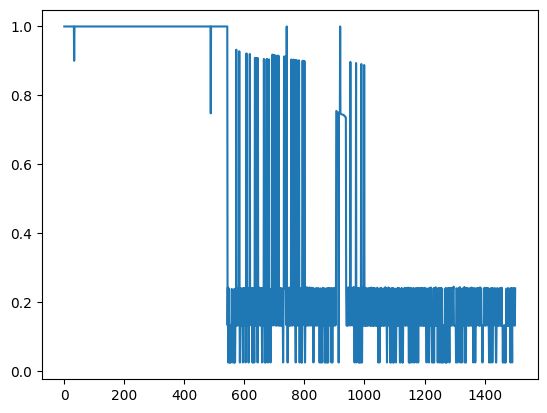

In [34]:
plt.plot(df["total_score"])

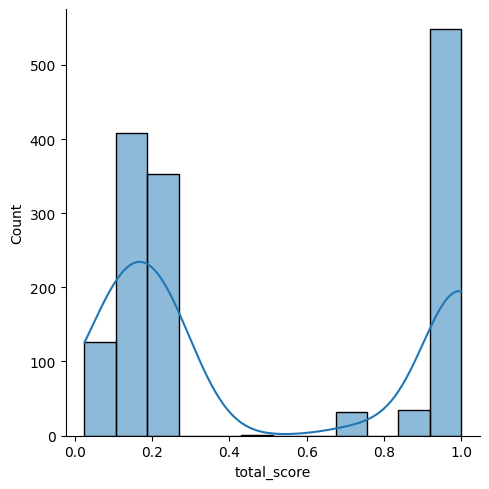

In [148]:
sns.displot( data=df["total_score"], kde=True )

<Axes: xlabel='total_score'>

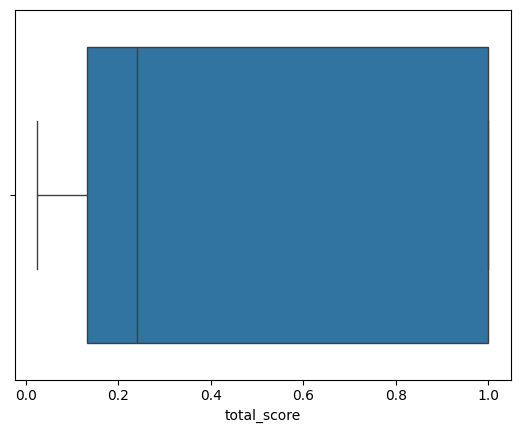

In [149]:
sns.boxplot(x=df["total_score"])

In [150]:
df = link_df.filter(F.col('match_status') == 1).select("total_score").toPandas()

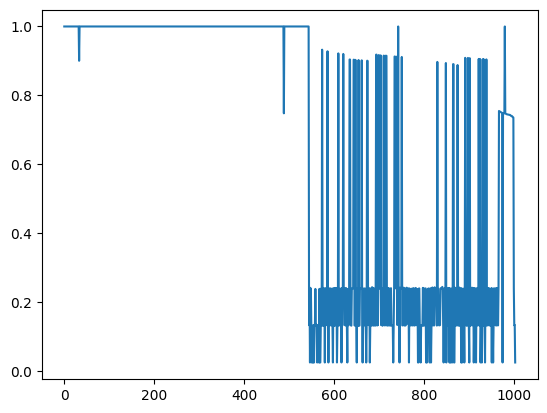

In [151]:
plt.plot(df["total_score"])

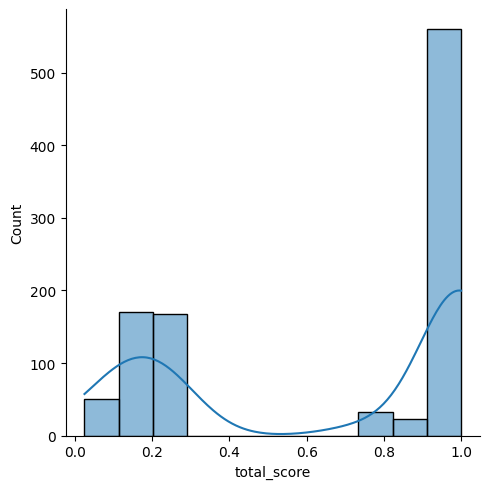

In [152]:
sns.displot( data=df["total_score"], kde=True )

<Axes: xlabel='total_score'>

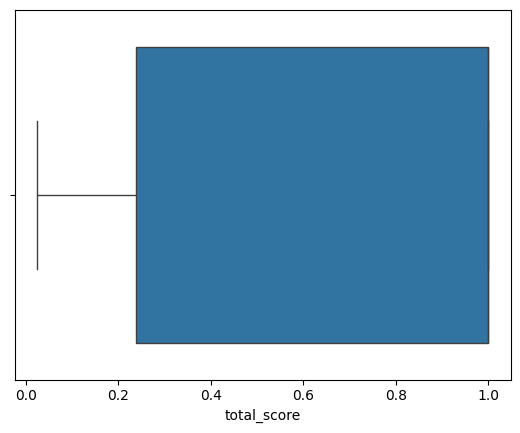

In [153]:
sns.boxplot(x=df["total_score"])

In [154]:
df = link_df.filter(F.col('match_status') == 0).select("total_score").toPandas()

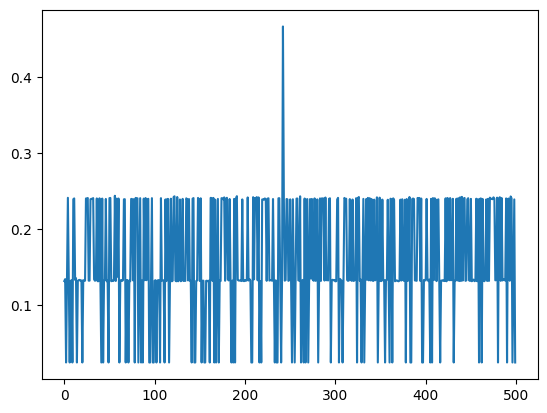

In [155]:
plt.plot(df["total_score"])

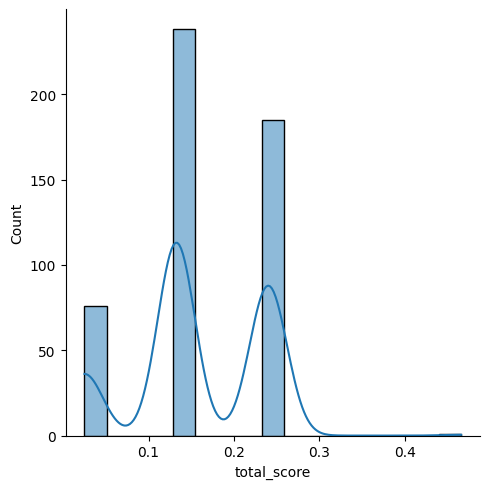

In [156]:
sns.displot( data=df["total_score"], kde=True )

<Axes: xlabel='total_score'>

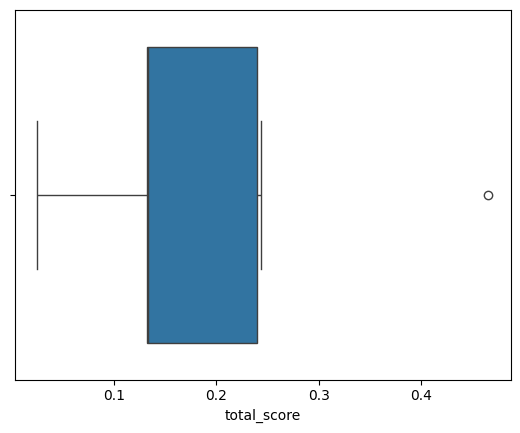

In [157]:
sns.boxplot(x=df["total_score"])